In [1]:
from zipfile import *
import cv2 
from scipy import io
import scipy
import os
import pandas as pd
import imgaug as ia
from imgaug import augmenters as iaa
import imageio
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import re
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D,Dense, Dropout,Input
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
import pickle
from tensorflow.keras.models import load_model

In [2]:
colnames = ['filename','xmin','ymin','xmax','ymax','class']
cat = pd.read_csv('CatDog/cat.csv',header=None,names=colnames)
dog =  pd.read_csv('CatDog/dog.csv',header= None,names=colnames)

In [3]:
labels_df = pd.concat([cat,dog],ignore_index=True)
labels_df

,filename,xmin,ymin,xmax,ymax,class
0,cat.0.jpg,126,83,354,243,cat
1,cat.1.jpg,52,31,299,278,cat
2,cat.10.jpg,2,42,458,495,cat
3,cat.11.jpg,141,14,361,385,cat
4,cat.12.jpg,38,19,241,191,cat
...,...,...,...,...,...,...
1095,dog.95.jpg,5,43,472,321,dog
1096,dog.96.jpg,26,1,427,356,dog
1097,dog.97.jpg,184,23,440,313,dog
1098,dog.98.jpg,162,99,414,382,dog


In [4]:
labels_df.loc[labels_df['class']=='cat','filename'] = labels_df['class']+'/'+labels_df['filename']
labels_df.loc[labels_df['class']=='dog','filename'] = labels_df['class']+'/'+labels_df['filename']


In [5]:
labels_df

,filename,xmin,ymin,xmax,ymax,class
0,cat/cat.0.jpg,126,83,354,243,cat
1,cat/cat.1.jpg,52,31,299,278,cat
2,cat/cat.10.jpg,2,42,458,495,cat
3,cat/cat.11.jpg,141,14,361,385,cat
4,cat/cat.12.jpg,38,19,241,191,cat
...,...,...,...,...,...,...
1095,dog/dog.95.jpg,5,43,472,321,dog
1096,dog/dog.96.jpg,26,1,427,356,dog
1097,dog/dog.97.jpg,184,23,440,313,dog
1098,dog/dog.98.jpg,162,99,414,382,dog


In [13]:
# Convert Bounding Boxes Object to Array and to dataframe
def bounding_boxes_to_df(bounding_boxes_object):
  bounding_boxes_array = bounding_boxes_object.to_xyxy_array()
  df_bounding_boxes = pd.DataFrame(bounding_boxes_array,columns=['xmin', 'ymin', 'xmax', 'ymax'])
  return df_bounding_boxes

In [7]:
#Applying augmentations 
image_augmentations = iaa.SomeOf( 2,
    [                                 
    iaa.Affine(scale=(0.5, 1.5)),              # Scale the Images
    iaa.Affine(rotate=(-60, 60)),              # Rotate the Images
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),    # Shift the Image
    iaa.Fliplr(1),                             # Flip the Image
    iaa.Multiply((0.5, 1.5)),                  # Increase or decrease the brightness
    iaa.GaussianBlur(sigma=(1.0, 3.0)),        # Add Gaussian Blur
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))   # Add Gaussian Noise

])

In [14]:
image_directory = 'CatDog/'


In [9]:
#Performing augmentations and creating dataframe for augmented images
def image_aug(df, images_path, aug_images_path, augmentor, multiple = 3):
    
    # Fill this DataFrame with image attributes
    augmentations_df = pd.DataFrame(
        columns=['filename', 'xmin', 'ymin', 'xmax','ymax','class'])
    
    
    grouped_df = df.groupby('filename')

    
    if not os.path.exists(aug_images_path):
      os.mkdir(aug_images_path)

    for folder in df['class'].unique():
      if not os.path.exists(os.path.join(aug_images_path, folder)):
        os.mkdir(os.path.join(aug_images_path, folder))

    for i in range(multiple):
      
      # Post Fix we add to the each different augmentation of one image
      image_postfix = str(i)

      # Loop to perform the augmentations
      for filename in df['filename'].unique():

        augmented_path = os.path.join(aug_images_path, filename)+image_postfix+'.jpg'

        # Take one image at a time with its information
        single_image = grouped_df.get_group(filename)
        single_image = single_image.reset_index()
        single_image = single_image.drop(['index'], axis=1)   
        
       
        image = imageio.imread(os.path.join(images_path,filename))
        bounding_box_array = single_image.drop(['filename', 'class'], axis=1).values
        bounding_box = BoundingBoxesOnImage.from_xyxy_array(bounding_box_array, shape=image.shape)
        image_aug, bounding_box_aug = augmentor(image=image,bounding_boxes=bounding_box)   
        bounding_box_aug = bounding_box_aug.remove_out_of_image()
        bounding_box_aug = bounding_box_aug.clip_out_of_image()

        # Get rid of the the image if bounding box was discarded  
        if re.findall('Image...', str(bounding_box_aug)) == ['Image([]']:
            pass
        
        else:
        
          imageio.imwrite(augmented_path, image_aug) 

          # Update the image width and height after augmentation
          info_df = single_image.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
          for index, _ in info_df.iterrows():
              info_df.at[index, 'width'] = image_aug.shape[1]
              info_df.at[index, 'height'] = image_aug.shape[0]

        
          info_df['filename'] = info_df['filename'].apply(lambda x: x + image_postfix + '.jpg')

          bounding_box_df = bounding_boxes_to_df(bounding_box_aug)
          aug_df = pd.concat([info_df, bounding_box_df], axis=1) 
          augmentations_df = pd.concat([augmentations_df, aug_df])            
      
    
    augmentations_df = augmentations_df.reset_index()
    augmentations_df = augmentations_df.drop(['index'], axis=1)

    return augmentations_df

augmented_images_df = image_aug(labels_df, image_directory, 'aug_images', 
                                image_augmentations)

In [15]:
augmented_images_df.to_csv('augmented_images_df')
augmented_images_df

,filename,xmin,ymin,xmax,ymax,class,width,height
0,cat/cat.0.jpg0.jpg,53.444584,7.545836,281.444580,167.545837,cat,500.0,374.0
1,cat/cat.1.jpg0.jpg,0.000000,0.000000,300.000000,280.000000,cat,300.0,280.0
2,cat/cat.10.jpg0.jpg,91.419754,0.000000,489.000000,375.474396,cat,489.0,499.0
3,cat/cat.11.jpg0.jpg,70.000000,14.000000,290.000000,385.000000,cat,431.0,410.0
4,cat/cat.12.jpg0.jpg,41.354462,0.000000,282.599274,217.795334,cat,300.0,224.0
...,...,...,...,...,...,...,...,...
3291,dog/dog.95.jpg2.jpg,75.518257,104.435669,499.000000,332.000000,dog,499.0,332.0
3292,dog/dog.96.jpg2.jpg,81.415054,37.776119,391.810669,350.089966,dog,499.0,375.0
3293,dog/dog.97.jpg2.jpg,184.000000,23.000000,440.000000,313.000000,dog,499.0,375.0
3294,dog/dog.98.jpg2.jpg,0.000000,31.614191,207.431519,314.614197,dog,500.0,480.0


In [ ]:
#Normalizing bounding box values as well as mormalizing the images.
def preprocess_dataset(image_folder, classes_list, df, image_size = 300,):

  # Lists that will contain the whole dataset
  labels = []
  boxes = []
  img_list = []


  h = df['height']
  w = df['width']
  labels = list(df['class'])

  # Create a copy of the bounding box values and also normalize them 
  for x1, y1, x2, y2 in zip(list(df['xmin']/w), list(df['ymin']/h),list(df['xmax']/w), list(df['ymax']/h)):
    
    arr = [x1, y1, x2, y2]
    boxes.append(arr)

  #loop over each class and its labels 
  for class_folder in classes_list:  

    
    image_dir = os.path.join(image_folder, class_folder)
    img_files = sorted(os.listdir(image_dir))

    # Loop over each of the image and its label
    for image_file in img_files:

      # Full path Image
      img_path = os.path.join(image_dir, image_file)
      img  = cv2.imread(img_path)
      image = cv2.resize(img, (image_size, image_size)) 
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = image.astype("float") / 255.0

      # Append it to the list of images
      img_list.append(image)
      

  return labels, boxes, img_list


In [ ]:
image_size = 300
# Get Augmented images and bounding boxes
labels, boxes, img_list = preprocess_dataset('aug_images',sorted(['cat',  'dog']), augmented_images_df)

In [ ]:
# Convert labels to integers, then one hot encode them
label_encoder = preprocessing.LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
onehot_labels = to_categorical(integer_labels)

#Shuffling img_list, boxes and onehot_labels
combined_list = list(zip(img_list, boxes, onehot_labels))
random.shuffle(combined_list)
img_list, boxes, onehot_labels = zip(*combined_list)

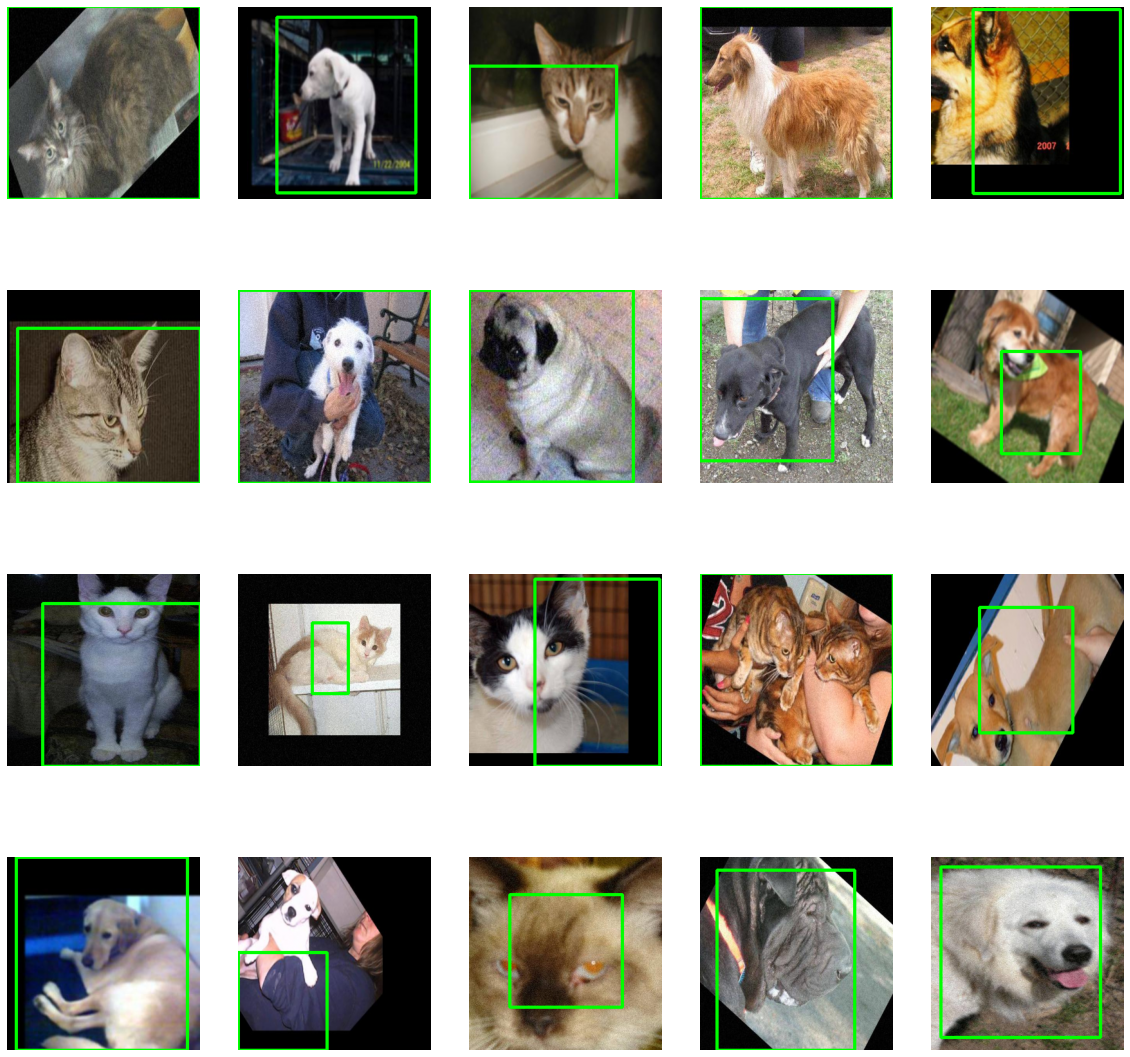

In [ ]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20));
random_range = random.sample(range(1, len(img_list)), 20)

for iteration, i in enumerate(random_range, 1):

  
    a1, b1, a2, b2 = boxes[i];
    x1 = a1 * image_size
    x2 = a2 * image_size
    y1 = b1 * image_size
    y2 = b2 * image_size
    image = img_list[i]

    # Draw bounding boxes on the image
    cv2.rectangle(image, (int(x1),int(y1)),
          (int(x2),int(y2)),(0,255,0),3);
    
    image = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, iteration);
    plt.imshow(image);
    plt.axis('off');

In [ ]:
# Split the data of images, labels and their annotations
train_images, val_images, train_labels, val_labels, train_boxes, val_boxes = train_test_split( np.array(img_list), 
                np.array(onehot_labels), np.array(boxes), test_size = 0.1,random_state = 43)

print('Total Training Images: {}, Total Test Images: {}'.format(
    len(train_images), 
    len(val_images)
    ))

Total Training Images: 2969, Total Test Images: 330


In [ ]:
# Load the NasNetMobile Model
N_mobile = tf.keras.applications.NASNetMobile( input_tensor = Input(
    shape=(image_size, image_size, 3)), 
    include_top=False, 
    weights='imagenet'
    )

19993432/19993432 [==============================] - 3s 0us/step


In [ ]:
def create_model(no_of_classes):

    # Freeze the whole model
    N_mobile.trainable = False
    
    # Taking the output feature maps from NASNETMobile
    base_model_output = N_mobile.output
    
    flattened_output = GlobalAveragePooling2D()(base_model_output)

    # Create Classification Head, final layer contains 
    # Ouput units = no. classes
    class_prediction = Dense(256, activation="relu")(flattened_output)
    class_prediction = Dense(128, activation="relu")(class_prediction )
    class_prediction = Dropout(0.2)(class_prediction)
    class_prediction = Dense(64, activation="relu")(class_prediction)
    class_prediction = Dropout(0.2)(class_prediction )
    class_prediction = Dense(32, activation="relu")(class_prediction)
    class_prediction = Dense(no_of_classes, activation='softmax',name="class_output")(class_prediction)

    # Create  Localization Head, final layer contains 4 nodes for x1,y1,x2,y2
    
    box_output = Dense(256, activation="relu")(flattened_output)
    box_output = Dense(128, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )
    box_output = Dense(64, activation="relu")(box_output)
    box_output = Dropout(0.2)(box_output )
    box_output = Dense(32, activation="relu")(box_output)
    box_predictions = Dense(4, activation='sigmoid',
                            name= "box_output")(box_output)

    # Combining the two heads
    model = Model(inputs=N_mobile.input, outputs= [box_predictions, class_prediction])

    return model

# Create the model for 2 classes
model = create_model(2)


Model Created


In [ ]:

# For classification we will have cateogirical crossentropy
# For the bouding boxes we will have mean squared error
losses = { 
    "box_output": "mean_squared_error",
    "class_output": "categorical_crossentropy"
    }
loss_weights = {
    "box_output": 1.0, 
    "class_output": 1.0
    }

metrics = {
    'class_output': 'accuracy', 
    'box_output':  'mse'
    }

stop = EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 40, 
                    restore_best_weights = True
                     )

reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.0002, 
                              patience = 30, min_lr = 1e-7, verbose = 1)

# Initialize Optimizer
opt = SGD(lr = 1e-3, momentum = 0.9)

# Compile the model with Adam optimizer
model.compile(optimizer = opt, loss = losses, loss_weights = loss_weights, 
    metrics = metrics)



In [ ]:
# Train the Model
history = model.fit(x = train_images, 
                    y= {
                        "box_output": train_boxes, 
                        "class_output": train_labels
                        }, 
                    validation_data=(
                        val_images, 
                        {
                          "box_output": val_boxes, 
                          "class_output": val_labels
                          }), batch_size = 16, epochs = 20, 
                    callbacks=[reduce_lr, stop])

Epoch 1/20
186/186 [==============================] - 157s 771ms/step - loss: 0.7807 - box_output_loss: 0.0990 - class_output_loss: 0.6816 - box_output_mse: 0.0990 - class_output_accuracy: 0.5504 - val_loss: 0.6958 - val_box_output_loss: 0.0443 - val_class_output_loss: 0.6514 - val_box_output_mse: 0.0443 - val_class_output_accuracy: 0.6242 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 137s 738ms/step - loss: 0.6806 - box_output_loss: 0.0306 - class_output_loss: 0.6500 - box_output_mse: 0.0306 - class_output_accuracy: 0.6224 - val_loss: 0.6471 - val_box_output_loss: 0.0214 - val_class_output_loss: 0.6257 - val_box_output_mse: 0.0214 - val_class_output_accuracy: 0.6848 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 132s 709ms/step - loss: 0.6608 - box_output_loss: 0.0217 - class_output_loss: 0.6391 - box_output_mse: 0.0217 - class_output_accuracy: 0.6426 - val_loss: 0.6411 - val_box_output_loss: 0.0197 - val_class_output_loss: 0.6214 - val_box_out

In [ ]:
model.save('catdog.h5')

In [17]:
model = load_model('catdog.h5')

In [18]:
classes_list = ['cat',  'dog']

In [19]:
global label_names
label_names = sorted(classes_list)

In [45]:

def predict(image, returnimage = False,  scale = 1):
  processed_image = preprocess(image)
  results = model.predict(processed_image)
  label, (x1, y1, x2, y2), confidence = postprocess(image, results)

  #Annotate the image
  cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 100), 2)
  cv2.putText( image, '{}'.format(label, confidence), (x1, y2 ), cv2.FONT_HERSHEY_COMPLEX, scale,(200, 55, 100),1)
  plt.figure(figsize=(10,10))
  plt.imshow(image[:,:,::-1])

  return label,(x1,y1,x2,y2), np.max(confidence) 

In [37]:

def preprocess(img, image_size = 300):
  
    image = cv2.resize(img, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float") / 255.0 

    # Expand dimensions as predict expect image in batches
    image = np.expand_dims(image, axis=0) 
    return image

In [38]:
def postprocess(image, results):

    bounding_box, class_probs = results
    class_index = np.argmax(class_probs)
    class_label = label_names[class_index]
    h, w = image.shape[:2]
    x1, y1, x2, y2 = bounding_box[0]
    # Convert the coordinates from relative to actual values
    x1 = int(w * x1)
    x2 = int(w * x2)
    y1 = int(h * y1)
    y2 = int(h * y2)
    return class_label, (x1,y1,x2,y2),class_probs

1/1 [==============================] - 0s 68ms/step
cat (80, 54, 537, 532) 0.98130655


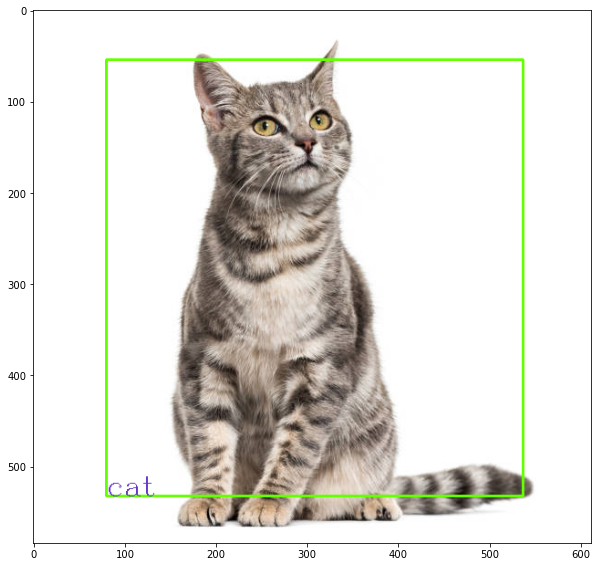

In [47]:
image = cv2.imread('C:/Users/lihsu/cat11.jpg' )
label, coordinates, confidence = predict(image, scale = 1)
print(label,coordinates,confidence) 
